# Ensemble Learning
https://www.geeksforgeeks.org/stacking-in-machine-learning-2/
https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/
https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

**Load files**

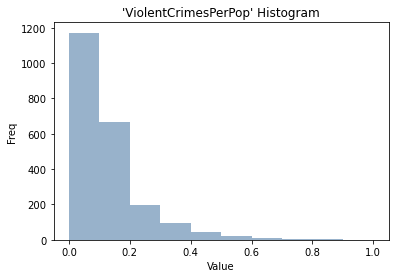

(1549, 100)
(665, 100)


In [14]:
%run alt_Preprocessing.ipynb

In [15]:
# import packages
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.layers import Dropout, Dense
from keras.models import Sequential
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [16]:
# Load train and test sets from Preprocessing file
x_train = x_train
y_train = y_train
x_test = x_test
y_test = y_test

In [17]:
# Set classes based on classification complexity decided in pre-processing
classes = {'LowCrime': 0, 'HighCrime': 1}

In [18]:
# Load function for plotting confusion matrix
def plot_confusion_matrix(train_pred, train, dom):
    cf = confusion_matrix(train_pred,train)
    sns.heatmap(cf,annot=True,yticklabels=classes,xticklabels=classes,cmap='Blues', fmt='g')
    plt.title(f'{dom} Confusion matrix')
    plt.tight_layout()
    plt.show()

**Paste Models from Files**

In [23]:
# Function for neural networks

def create_model(optimizer='Adagrad', init='glorot_uniform', neurons=1, dropout_rate=0.2):
    # create model
    model = Sequential()
    # adding more layers by trial and error
    model.add(Dense(neurons, input_dim=100, kernel_initializer='uniform', activation='linear', kernel_constraint=maxnorm(4)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid')) # kernel_initializer=init
    print(model.summary())
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [24]:
# Load models from files, but for now...
dt_model = DecisionTreeClassifier(ccp_alpha=0.01, random_state=40)
svm_model = SVC(C=1, gamma=1, probability=True)
b_model = BernoulliNB(alpha=1, binarize=None)
nn_model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=5, verbose=0)

**Implement Ensemble Stacking Classifier**

In [25]:
# Fit & Train model
lr = LogisticRegression()  # defining meta-classifier
clf_stack = StackingClassifier(classifiers =[dt_model, svm_model, b_model, nn_model], meta_classifier = lr, use_probas = True, use_features_in_secondary = True)
model_stack = clf_stack.fit(x_train, y_train)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 101       
_________________________________________________________________
dropout_2 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________
None


c:\programdata\anaconda3\envs\geospatial\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
c:\programdata\anaconda3\envs\geospatial\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


- use_probas = True indicates the Stacking Classifier uses the prediction probabilities as an input instead of using predictions classes.
- use_features_in_secondary = True indicates Stacking Classifier not only take predictions as an input but also uses features in the dataset to predict on new data.

In [26]:
# Train model
model_stack = clf_stack.fit(x_train, y_train)   # training of stacked model
pred_stack = model_stack.predict(x_test)       # predictions on test data using stacked model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1)                 101       
_________________________________________________________________
dropout_3 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________
None


c:\programdata\anaconda3\envs\geospatial\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
c:\programdata\anaconda3\envs\geospatial\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\programdata\anaconda3\envs\geospatial\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is depreca

In [27]:
# Evaluate model
acc_stack = accuracy_score(y_test, pred_stack)  # evaluating accuracy
print('Accuray score of Stacked model:', acc_stack * 100)

Accuray score of Stacked model: 86.46616541353383


**Perform k-fold cross validation**

In [ ]:
# Perform k-fold split on training data
kf =KFold(n_splits=10, shuffle=True, random_state=42)
kfold_scores = {}
for i in range(2,12):
    kf =KFold(n_splits=i, shuffle=True, random_state=42)
    score = cross_val_score(model_stack, x_train, y_train, scoring='accuracy', cv=kf, n_jobs=-1)
    res = {str(i): score.mean()}
    kfold_scores.update(res)

for key in kfold_scores:
    plt.bar([key], kfold_scores[key], label=key, color=(0.2, 0.4, 0.6, 0.6))

plt.title('K-Fold vs Train Data Accuracy')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.ylim(0.83, 0.8675)
plt.show()

In [ ]:
# Check k-fold split
kf =KFold(n_splits=7, shuffle=True, random_state=42)
score = cross_val_score(model_stack, x_train, y_train, scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')
print(f'Standard Deviation in score: {"{:.2f}".format(score.std())}')


# Good - most accurate and minimal variation



In [ ]:
# Compare train &  test data
y_train_pred = model_stack.predict(x_train)
y_test_pred = model_stack.predict(x_test)

print(f'Ensemble Train Model Accuracy(in %): {accuracy_score(y_train_pred,y_train)*100}')
print(f'Ensemble Test Model Accuracy(in %): {accuracy_score(y_test_pred,y_test)*100}')
plot_confusion_matrix(y_train_pred,y_train,dom='Train')
plot_confusion_matrix(y_test_pred,y_test,dom='Test')